# Webinar: Introduction to robust control

**A step-by-step introduction on how to create and analyze robust controls**

Here we introduce the essential concepts behind robust control. We create a model of noise on a quantum computer and simulate its performance. Then we show how to create controls that are robust to this noise process. We demonstrate the control's robustness with a simulation. Finally, we provide a geometric explanation of how these controls work.

## Imports and initialization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qctrlvisualizer as qv
from attr import asdict

from qctrl import Qctrl

# Starting a session with the API
qctrl = Qctrl()

In [2]:
# Define standard matrices
identity = np.array([[1.0, 0.0], [0.0, 1.0]], dtype=np.complex)
sigma_x = np.array([[0.0, 1.0], [1.0, 0.0]], dtype=np.complex)
sigma_y = np.array([[0.0, -1j], [1j, 0.0]], dtype=np.complex)
sigma_z = np.array([[1.0, 0.0], [0.0, -1.0]], dtype=np.complex)
sigma_m = np.array([[0.0, 1.0], [0.0, 0.0]], dtype=np.complex)
sigmas = [sigma_x, sigma_y, sigma_z]
sigma_names = ["X", "Y", "Z"]
not_gate = np.array([[0.0, -1.0], [1.0, 0.0]])

# Plotting and formatting methods
plt.style.use(qv.get_qctrl_style())


def plot_simulation_trajectories(figure, times, coherent_samples, noisy_trajectories):
    ideal_bloch_sphere_coords = np.array(
        [
            [
                np.real(
                    np.dot(
                        sample.state_vector.conj(),
                        np.matmul(sigma, sample.state_vector),
                    )
                )
                for sigma in sigmas
            ]
            for sample in coherent_samples
        ]
    )
    noisy_bloch_sphere_coords = np.array(
        [
            [
                [
                    np.real(
                        np.dot(
                            sample.state_vector.conj(),
                            np.matmul(sigma, sample.state_vector),
                        )
                    )
                    for sigma in sigmas
                ]
                for sample in trajectory.samples
            ]
            for trajectory in noisy_trajectories
        ]
    )
    figure.set_figheight(6.0)
    figure.set_figwidth(7.0)
    axes = figure.subplots(nrows=3, ncols=1, sharex=True, sharey=False, squeeze=False)[
        :, 0
    ]
    for a in range(3):
        axes[a].set_ylabel(sigma_names[a])
        axes[a].set_ylim([-1.1, 1.1])
        for t in range(noisy_bloch_sphere_coords.shape[0]):
            axes[a].plot(
                times * 1e6,
                noisy_bloch_sphere_coords[t, :, a],
                "--",
                color="#680CE9",
                alpha=0.25,
            )
        axes[a].plot(times * 1e6, ideal_bloch_sphere_coords[:, a], "-", color="#680CE9")
    axes[2].set_xlabel("Time ($\mu$s)")
    axes[0].set_title("Bloch sphere coordinates")


def plot_simulation_noise_directions(figure, times, coherent_samples):
    figure.set_figheight(6.0)
    figure.set_figwidth(7.0)
    noise_operator_directions = np.array(
        [
            [
                0.5
                * np.real(
                    np.trace(
                        np.matmul(
                            sigma,
                            np.matmul(
                                sample.evolution_operator.conj().T,
                                np.matmul(sigma_z, sample.evolution_operator),
                            ),
                        )
                    )
                )
                for sigma in sigmas
            ]
            for sample in coherent_samples
        ]
    )
    axes = figure.subplots(nrows=3, ncols=1, sharex=True, sharey=False, squeeze=False)[
        :, 0
    ]
    for a in range(3):
        axes[a].set_ylabel(sigma_names[a])
        axes[a].set_ylim([-1.1, 1.1])
        axes[a].plot(
            robust_point_times * 1e6,
            noise_operator_directions[:, a],
            "-",
            color="#680CE9",
        )
        axes[a].fill_between(
            robust_point_times * 1e6,
            0,
            noise_operator_directions[:, a],
            color="#680CE9",
            alpha=0.25,
        )
    axes[2].set_xlabel("Time ($\mu$s)")
    axes[0].set_title("Bloch sphere directions")


def plot_noise_spectral_density(figure, nsd_samples):
    frequencies = np.array([sample["frequency"] for sample in nsd_samples])
    powers = np.array([sample["power"] for sample in nsd_samples])
    axes = figure.subplots(nrows=1, ncols=1, sharex=True, sharey=False, squeeze=False)[
        0, 0
    ]
    axes.plot(frequencies / 1e6, powers * 1e6)
    axes.fill_between(frequencies / 1e6, 0, powers * 1e6, alpha=0.25)
    axes.set_xlabel("Frequency (MHz)")
    axes.set_ylabel("Power density (1/MHz)")
    axes.set_title("Dephasing noise spectral density")


def pm_format(average, std):
    return "{:.4f}".format(average) + "+/-" + "{:.4f}".format(std)


def bandwidth_limited_pwc_signal(
    name, duration, segment_count, max_rabi_rate, cutoff_frequency
):

    # create a raw pwc_signal where the amplitude of each segment is an optimization variables
    raw_signal = qctrl.operations.pwc_signal(
        values=qctrl.operations.bounded_optimization_variable(
            count=segment_count, lower_bound=-max_rabi_rate, upper_bound=max_rabi_rate
        ),
        duration=duration,
    )

    # pass the signal through a bandwidth limited filter
    filtered_signal = qctrl.operations.convolve_pwc(
        raw_signal, qctrl.operations.sinc_integral_function(cutoff_frequency)
    )

    # resample the smooth filtered signal as a pwc_signal
    final_signal = qctrl.operations.discretize_stf(
        stf=filtered_signal,
        duration=robust_duration,
        segments_count=segment_count,
        name=name,
    )

    return final_signal

## Single qubit with dephasing noise

To better understand how noise affects a quantum computer we are going to create a simulation.

We are going to look at one of the simplest operations on a quantum computer applying a NOT gate to an individual superconducting qubit. We are also going to assume there is some noisy magnetic fields in the environment that is having a negative effect on its operation.

To start we write down a Hamiltonian, which will mathematically describe this physical system:

\begin{align*}
H_{\rm total}(t) = & H_{\rm control}(t) + H_{\rm noise}(t).
\end{align*}

### Control: Standard microwave pulse that creates a NOT Gate

The control part of the Hamiltonian is:

\begin{align}
H_{\rm control}(t) = \Omega_{\rm I}(t) \sigma_{x}/2 + \Omega_{\rm Q}(t) \sigma_{y}/2.
\end{align}

Where $\Omega_I(t)$ and $\Omega_Q(t)$ are the time-dependent Rabi rate created by the IQ modulated microwave pulse applied to control the qubits state, which couples to the qubit state through the $\sigma_k$ operators.

We are trying to apply a NOT gate to the qubit. The simplest way to do this is to apply a Q modulated microwave pulse at the maximum Rabi rate $\Omega_{\rm Q}(t) = \Omega_{\rm max}$ for a duration of $\pi/\Omega_{\rm max}$, while the I modulated microwave pulse is set to zero $\Omega_{\rm I}(t) = 0$. We will call this the standard NOT gate. 

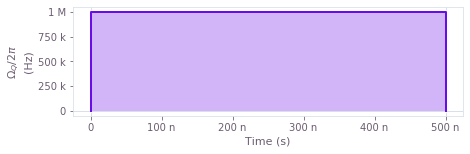

In [3]:
omega_max = 2 * np.pi * 1e6  # Hz
standard_duration = np.pi / omega_max  # s

standard_pulse_segments = [
    qctrl.types.ComplexSegmentInput(duration=standard_duration, value=omega_max),
]

plot_segments = {
    "$\Omega_Q$": [
        {"duration": segment.duration, "value": segment.value}
        for segment in standard_pulse_segments
    ]
}

qv.plot_controls(plt.figure(), plot_segments)
plt.show()

### Noise: Magnetic field with a 1/f spectrum

The noise part of the Hamiltonian is:
\begin{align}
H_{\rm noise}(t) = \eta(t) \sigma_z / 2.
\end{align}

We treat the noisy magnetic field environment as a classical noise process $\eta(t)$ coupled to the quantum system with a noise operator $\sigma_z$. This approximate model is often reasonable for real quantum computing hardware when the decoherence time (T2) is the limiting factor, being much shorter than the relaxation time (T1) of the qubits. 

The noise process $\eta(t)$ is sampled from a noise spectral density that follows a power law: 
\begin{align}
S_{\eta}(\omega) = \frac{\omega_{\rm cutoff}^{a-1}}{\omega^a + \omega_{\rm cutoff}^a},
\end{align}
Where $\omega_{\rm cutoff}$ is the cutoff frequency and $a$ is the order of the power law. It is common for  magnetic field environments to follow 1/f power law ($a=1$) where low frequency noise dominates. 

A more complete description of the noise in the system would include a full quantum mechanical model of the environment, but such a model would be too complex to simulate on a classical computer and hence we must choose an appropriate approximation.

*See Also:* For a comprehensive introduction to modeling quantum systems with noisy enviroments see [The Theory of Open Quantum Systems by Breuer and Petruccione](https://www.amazon.com.au/Theory-Open-Quantum-Systems/dp/0199213909)

Different physical processes will couple to the quantum computer through different noise operators. The key to getting a good simulation is to identify the noises that most significantly affect your qubits. 

*See Also:* BOULDER OPAL's [noise characterization feature](https://docs.q-ctrl.com/boulder-opal/user-guides/noise-characterization-and-reconstruction) can be used to identifying and quantifying noise affecting quantum devices.

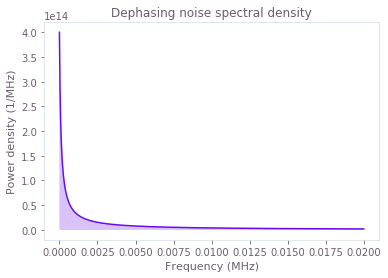

In [4]:
def power_spectrum(frequencies, frequency_cutoff, power):
    return frequency_cutoff ** (power - 1) / (
        frequencies ** power + frequency_cutoff ** power
    )


frequencies = np.linspace(0, 2.0e4, 1000)
power_densities = 4e10 * power_spectrum(frequencies, 1.0e2, 1.0)
nsd_sampled_points = [
    {"frequency": f, "power": p, "power_uncertainty": 0.0, "weight": 0.0}
    for f, p in zip(frequencies, power_densities)
]

plot_noise_spectral_density(plt.figure(), nsd_sampled_points)

## Simulation of standard NOT Gate

Now that we have a Hamiltonian we can create a simulation. The control we have is a `shift` with $\sigma_x$ as the `operator` and $\Omega(t)$ is the `pulse`. The noise we have is an `additive noise` with $\sigma_z$ as the `operator` and  $S_\eta(\omega)$ is the `linear_piecewise_noise_spectral_density`.

*See also:* The [Setting up quantum systems](https://docs.q-ctrl.com/boulder-opal/user-guides/setting-up-quantum-systems) user guide has detailed instructions on how to translate a Hamiltonian to a the Q-CTRL model of a system.

In [5]:
standard_control = qctrl.types.colored_noise_simulation.Shift(
    control=standard_pulse_segments, operator=sigma_y / 2
)

noise_drift = qctrl.types.colored_noise_simulation.Drift(
    operator=sigma_z / 2.0,
    noise=qctrl.types.colored_noise_simulation.Noise(
        power_densities=power_densities,
        frequency_step=frequencies[1],
        time_domain_sample_count=1000,
    ),
)

target = qctrl.types.TargetInput(operator=not_gate)

Now we can create a simulation of the qubit in a noisy environment.

*See also:* The [simulation user guide](https://docs.q-ctrl.com/boulder-opal/user-guides/simulation) explains how to create multiple types of simulations.

In [6]:
standard_point_times = np.linspace(0, standard_duration, 100)

standard_noisy_simulation_result = qctrl.functions.calculate_colored_noise_simulation(
    duration=standard_duration,
    sample_times=standard_point_times,
    shifts=[standard_control],
    drifts=[noise_drift],
    trajectory_count=5,
    initial_state_vector=np.array([1.0, 0.0]),
    target=target,
)

100%|██████████| 100/100 [00:07<00:00, 13.09it/s]


For comparison we can also create a simulation of a system with no noise

In [7]:
standard_ideal_simulation_result = qctrl.functions.calculate_coherent_simulation(
    duration=standard_duration,
    sample_times=standard_point_times,
    shifts=[standard_control],
    initial_state_vector=np.array([1.0, 0.0]),
    target=target,
)

100%|██████████| 100/100 [00:03<00:00, 32.71it/s]


### Noisy trajectories of the qubit state

We can display the noisy trajectories of the qubit using the coordinates of the [Bloch sphere](https://en.wikipedia.org/wiki/Bloch_sphere) as a representation of the state. We can see that the noisy trajectories, shown with dotted lines, take us away from the ideal simulation path, shown with the solid line. Most importantly, the final state of noisy trajectories diverges from the ideal final state. This indicates that the noise will introduce errors into our calculation and affect the outcomes of an algorithm that we want to run.

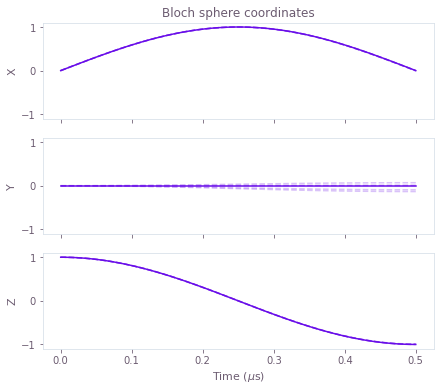

In [8]:
plot_simulation_trajectories(
    plt.figure(),
    standard_point_times,
    standard_ideal_simulation_result.samples,
    standard_noisy_simulation_result.trajectories,
)
plt.show()

### Average gate infidelity of standard NOT gate

The results above are specific to a particular initial state. We can quantify the *average* performance of the gate under noise by looking at the average gate infidelity, defined as:

\begin{align}
\mathcal{I}_{\rm gate} = 1 - \mathbb{E}[ \rm{Tr}[ U_{\rm target}^\dagger(T) U_{\rm total}(T) ] ],
\end{align}

where $U_{k}(T)$ is the solution to $\dot{U}_{k}(t) = -i H_{k} U_{k}(t)$, $U_{\rm target}$ is the target unitary, in this case a NOT gate, and $\mathbb{E}[ \cdot ]$ is the classical stochastic average. An estimate of this number is automatically calculated when you provide a target to a stochastic simulation in BOULDER OPAL.

In [9]:
standard_final_sample = standard_noisy_simulation_result.average_samples[-1]
print("Average gate infidelity:")
print(
    pm_format(
        standard_final_sample.average_infidelity,
        standard_final_sample.average_infidelity_uncertainty,
    )
)

Average gate infidelity:
0.0016+/-0.0008


## Filter function framework

The filter function framework allows us to analyze the robustness of controls, and furthermore design them. The filter function is defined as the magnitude of the Fourier transform of the noise Hamiltonian in the control frame, explicitly:

\begin{align}
F(\omega) = \left|\left| \tilde{H}_{\rm noise}^{\rm (control)}(\omega) \right|\right|_2^2,
\end{align}

where $H_{\rm noise}^{\rm (control)}(t) = U_{\rm control}(t) H_{\rm noise}(t) U_{\rm control}^\dagger(t)$, $\left|\left| A \right| \right|_2 = \sqrt{\sum_{i,j} |A_{i,j}|^2}$  and $ \tilde{f}(\omega) = \int_{-\infty}^{\infty} dt f(t) e^{-i \omega t}$.

If we assume that the noise Hamiltonian $H_{\rm noise}$ is small compared to the control Hamiltonian $H_{\rm control}$, $H_{\rm noise}$ can be transformed to be traceless $\rm{Tr}[H_{\rm noise}]=0$, and the control Hamiltonian would produce the target unitary if three was no noise. We can then show that the average infidelity contribution from the noise is
\begin{align}
\mathcal{I}_{\rm gate} \approx \int_{-\infty}^{\infty} d\omega S(\omega) F(\omega).
\end{align}

This result demonstrates that the filter function quantifies the relative contribution of noise at different frequencies to the average infidelity. 

*See also:* For a derivation of a more general version of this result see [Software tools for quantum control: Improving quantum computer performance through noise and error suppression by Ball et al.](https://arxiv.org/abs/2001.04060).

### Filter function of a standard NOT gate

The standard NOT gate defined above is not robust to noise at low frequencies. This can be seen by examining its filter function.

In [10]:
sample_count = 3000
interpolated_frequencies = omega_max * np.logspace(-8, 1, 1000, base=10)

filter_noise_drift = qctrl.types.filter_function.Drift(
    noise=True, operator=sigma_z / 2.0
)

standard_filter_function_results = qctrl.functions.calculate_filter_function(
    duration=standard_duration,
    frequencies=interpolated_frequencies,
    sample_count=sample_count,
    shifts=[standard_control],
    drifts=[filter_noise_drift],
)

100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


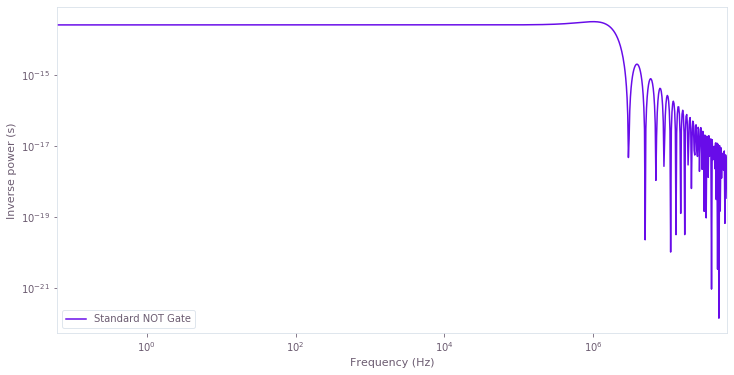

In [11]:
standard_filter_function_interpolated_points = [
    asdict(sample) for sample in standard_filter_function_results.samples
]

qv.plot_filter_functions(
    plt.figure(), {"Standard NOT Gate": standard_filter_function_interpolated_points}
)
plt.show()

### Gate infidelity approximated with filter function

We can also approximately calculate the gate infidelity using the filter function. As long as the noise is small compared to the control, this calculation will be accurate.

In [12]:
integral_max = 1e5

standard_frequencies = np.array(
    [
        sample.frequency
        for sample in standard_filter_function_results.samples
        if sample.frequency < integral_max
    ]
)
standard_inverse_powers = np.array(
    [
        sample.inverse_power
        for sample in standard_filter_function_results.samples
        if sample.frequency < integral_max
    ]
)
standard_filter_function_infidelity = np.trapz(
    y=standard_inverse_powers * 4e10 * power_spectrum(standard_frequencies, 1.0e2, 1.0),
    x=standard_frequencies,
)

print("Approximate filter function gate infidelity:")
print("{:4f}".format(standard_filter_function_infidelity))

Approximate filter function gate infidelity:
0.006994


## Robust control design

The filter function framework can be used to design robust controls. We treat the design problem as a multi-objective optimization problem. First we assume the control field is parametrized by a set of variables $\Omega_{\rm candidate}(\underline{v},t)$. 

The first target of our optimization is to ensure that our optimized pulse performs the correct operation. To do this we need to minimize the infidelity of the control:
\begin{align}
\mathcal{I}_{\rm control} = \rm{Tr}[U_{\rm control}^\dagger(T) U_{\rm target}(T)],
\end{align}
This quantifies how close the control is to the target operation if there is no noise.

The second target of our optimization is to ensure that our optimized pulse is robust to the noise. It is common for physically relevant noise processes to be dominated by low frequency noise, in this case it simplifies the numerical calculation to minimize just the zero frequency part of the filter function. We call this the infidelity of the noise:
\begin{align}
\mathcal{I}_{\rm noise} = w^2 \left|\left| \int dt H_{\rm noise}^{\rm (control)}(t) \right|\right|_2^2,
\end{align}
where $w$ is a relative weight of the filter cost compared to the operation, a good value for additive noises is $w=1/T$.

The multi-objective optimization problem can be represented as minimizing the cost
\begin{align}
\mathcal{I}_{\rm robust}(\underline{v}) = \mathcal{I}_{\rm control}(\underline{v}) + \mathcal{I}_{\rm noise}(\underline{v}).
\end{align}


If we can find a control where $\mathcal{I}_{\rm robust}(\underline{v})$ is very close to zero, we can be sure that it will both complete the correct operation and be robust to low frequency noise.

### Optimizing a robust NOT gate

We can create a robust NOT gate using the BOULDER OPAL optimizer. The [optimization feature](https://docs.q-ctrl.com/boulder-opal/user-guides/optimization) allows the user to define an optimization with arbitrary pulse constraints. 

We are going to construct two control pulses $\Omega_I(\underline{v},t)$ and $\Omega_Q(\underline{v},t)$ which have a maximum Rabi rate $\Omega_{\rm max}$ and a bandwidth limit defined by a cutoff frequency $\Omega_{\rm cutoff}$. 

The optimizer requires that you define the quantum system as a `graph` that represents how a set of `optimization_variables` an `infidelity` you want to minimize. A series of convenience methods makes 
creating this `graph` straightforward once you have mathematically written down the total Hamiltonian ($H_{\rm total}$). Below we show how to create a `graph` for optimizing a qubit with dephasing noise. On each line, we write down what the current variable represents in the mathematical equation of the total Hamiltonian.

We restate the entire Hamiltonian below so we can easily refer to it:
\begin{align}
H_{\rm total}(t) = & H_{\rm control}(t) + H_{\rm noise}(t), \\
H_{\rm control}(t) = & \Omega_{\rm I}(t) \sigma_{x}/2 + \Omega_{\rm Q}(t) \sigma_{y}/2, \\
H_{\rm noise}(t) = & \eta(t) \sigma_z / 2.
\end{align}

In [13]:
robust_duration = 3.0 * standard_duration
omega_cutoff = 1e7
segment_count = 100

with qctrl.create_graph() as graph:

    # Omega_I(v,t)
    pulse_i = bandwidth_limited_pwc_signal(
        name="I",
        duration=robust_duration,
        segment_count=segment_count,
        max_rabi_rate=omega_max,
        cutoff_frequency=omega_cutoff,
    )

    # Omega_Q(v,t)
    pulse_q = bandwidth_limited_pwc_signal(
        name="Q",
        duration=robust_duration,
        segment_count=segment_count,
        max_rabi_rate=omega_max,
        cutoff_frequency=omega_cutoff,
    )

    # Omega_I(t) sigma_x/2
    robust_control_i = qctrl.operations.pwc_operator(
        signal=pulse_i, operator=sigma_x / 2.0
    )

    # Omega_Q(t) sigma_y/2
    robust_control_q = qctrl.operations.pwc_operator(
        signal=pulse_q, operator=sigma_y / 2.0
    )

    # H_control = Omega_I(t) sigma_x/2 + Omega_Q(t) sigma_y/2
    control_hamiltonian = qctrl.operations.pwc_sum([robust_control_i, robust_control_q])

    # sigma_z / 2w
    noise_operator = qctrl.operations.constant_pwc_operator(
        robust_duration, sigma_z / 2.0 / robust_duration
    )

    # create U_target
    target_unitary = qctrl.operations.target(operator=not_gate)

    # create I_robust(v) = I_control(v) + I_noise(v)
    infidelity = qctrl.operations.infidelity_pwc(
        hamiltonian=control_hamiltonian,
        noise_operators=[
            noise_operator,
        ],
        target_operator=target_unitary,
        name="infidelity",
    )

When you run an optimization, a series of searches are performed and the pulse with the smallest cost is returned. The optimization is stochastic and therefore a different result will be returned each time, but they will always satisfy the constraints. 

A pulse that is both robust and completes the correct operation will have a cost which is very close to zero. If the cost returned does not satisfy this condition, you may need to reduce your constraints. Increasing the total duration and/or the number of segments will often help.

In [33]:
optimization_result = qctrl.functions.calculate_optimization(
    cost_node_name="infidelity",
    output_node_names=["infidelity", "I", "Q"],
    graph=graph,
)

100%|██████████| 100/100 [00:08<00:00, 11.40it/s]


In [34]:
print("Best cost:")
print(optimization_result.cost)

Best cost:
1.6774540981820942e-10


Once you have completed an optimization with a good cost you can export the segments of the pulse to your device.

*See also:* For an example of exporting Q-CTRL pulse solutions to the IBM-Q Open Pulse format see [Superconducting qubits: Improving the performance of single qubit gates](https://docs.q-ctrl.com/boulder-opal/application-notes/superconducting-qubits-improving-the-performance-of-single-qubit-gates)

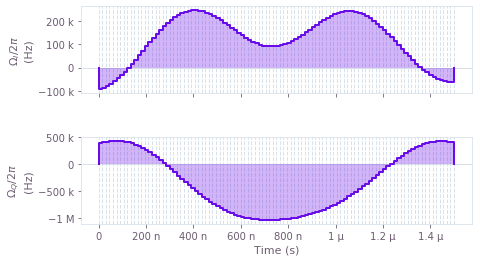

In [35]:
qv.plot_controls(
    plt.figure(),
    {
        "$\Omega_I$": optimization_result.output["I"],
        "$\Omega_Q$": optimization_result.output["Q"],
    },
)
plt.show()

### Filter function confirmation of the robust NOT gate

Now that we have our robust NOT gate, we can confirm it is robust by calculating its filter function. Note that the filter function has very small values for low frequencies, this indicates that the control will suppress low frequency noise. 

In [36]:
robust_pulse_segments_i = [
    qctrl.types.RealSegmentInput(duration=segment["duration"], value=segment["value"])
    for segment in optimization_result.output["I"]
]

robust_pulse_segments_q = [
    qctrl.types.RealSegmentInput(duration=segment["duration"], value=segment["value"])
    for segment in optimization_result.output["Q"]
]

robust_control_i = qctrl.types.colored_noise_simulation.Shift(
    control=robust_pulse_segments_i, operator=sigma_x / 2
)

robust_control_q = qctrl.types.colored_noise_simulation.Shift(
    control=robust_pulse_segments_q, operator=sigma_y / 2
)

sample_count = 3000
interpolated_frequencies = omega_max * np.logspace(-8, 1, 1000, base=10)

robust_filter_function_results = qctrl.functions.calculate_filter_function(
    duration=robust_duration,
    frequencies=interpolated_frequencies,
    sample_count=sample_count,
    shifts=[robust_control_i, robust_control_q],
    drifts=[filter_noise_drift],
)

100%|██████████| 100/100 [00:04<00:00, 23.38it/s]


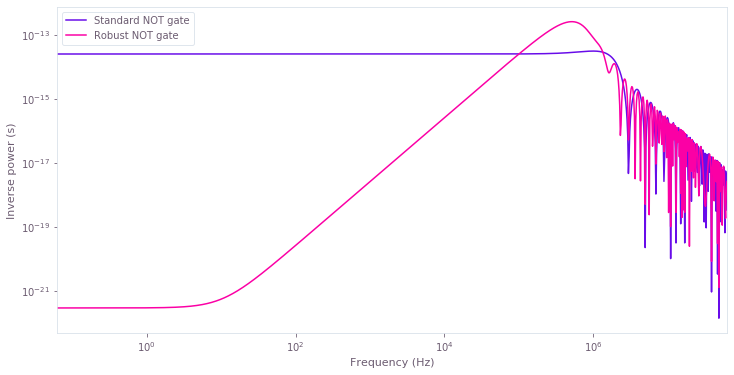

In [37]:
robust_filter_function_interpolated_points = [
    asdict(sample) for sample in robust_filter_function_results.samples
]

qv.plot_filter_functions(
    plt.figure(),
    {
        "Standard NOT gate": standard_filter_function_interpolated_points,
        "Robust NOT gate": robust_filter_function_interpolated_points,
    },
)
plt.show()

In [38]:
robust_frequencies = np.array(
    [
        sample.frequency
        for sample in robust_filter_function_results.samples
        if sample.frequency < integral_max
    ]
)
robust_inverse_powers = np.array(
    [
        sample.inverse_power
        for sample in robust_filter_function_results.samples
        if sample.frequency < integral_max
    ]
)
robust_filter_function_infidelity = np.trapz(
    y=robust_inverse_powers * 4e10 * power_spectrum(robust_frequencies, 1.0e2, 1.0),
    x=robust_frequencies,
)

print("Approximate filter function standard gate infidelity:")
print("{:4f}".format(standard_filter_function_infidelity))

print("Approximate filter function robust gate infidelity:")
print("{:4f}".format(robust_filter_function_infidelity))

Approximate filter function standard gate infidelity:
0.006994
Approximate filter function robust gate infidelity:
0.000501


## Simulation of robust NOT Gate

We can confirm the optimization has produced a NOT Gate that is robust to the magnetic field noise by performing a simulation where we swap the standard pulse with the robust robust pulse.

In [39]:
robust_point_times = np.linspace(0, robust_duration, 100)

robust_noisy_simulation_result = qctrl.functions.calculate_colored_noise_simulation(
    duration=robust_duration,
    sample_times=robust_point_times,
    shifts=[robust_control_i, robust_control_q],
    drifts=[noise_drift],
    trajectory_count=10,
    initial_state_vector=np.array([1.0, 0.0]),
    target=target,
)

100%|██████████| 100/100 [00:12<00:00,  7.81it/s]


In [40]:
robust_ideal_simulation_result = qctrl.functions.calculate_coherent_simulation(
    duration=robust_duration,
    sample_times=robust_point_times,
    shifts=[robust_control_i, robust_control_q],
    initial_state_vector=np.array([1.0, 0.0]),
    target=target,
)

100%|██████████| 100/100 [00:03<00:00, 32.85it/s]


### Noisy trajectories of the state with robust control

When we look at the noisy trajectories of the state with the robust NOT gate, we can see each of the trajectories finish significantly closer to the ideal simulation without noise. This confirms that the control we have developed is indeed robust. 

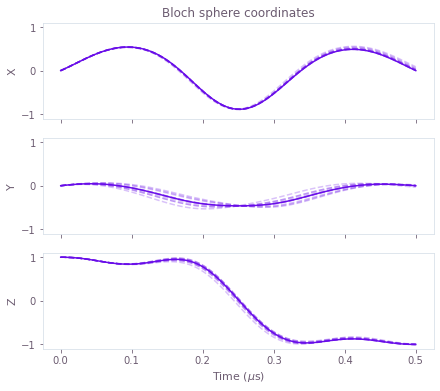

In [41]:
plot_simulation_trajectories(
    plt.figure(),
    standard_point_times,
    robust_ideal_simulation_result.samples,
    robust_noisy_simulation_result.trajectories,
)
plt.show()

### Average gate infidelity of robust NOT gate

The average infidelity of the robust operation is over an order of magnitude better than the standard NOT gate. For this example we have made the noise relatively large compared to the control to visually highlight the difference. The relative improvement is even more pronounced for smaller noise processes. 

In [42]:
robust_final_sample = robust_noisy_simulation_result.average_samples[-1]

print("Average gate infidelity:")

print("Average standard gate infidelity:")
print(
    pm_format(
        standard_final_sample.average_infidelity,
        standard_final_sample.average_infidelity_uncertainty,
    )
)

print("Average robust gate infidelity:")
print(
    pm_format(
        robust_final_sample.average_infidelity,
        robust_final_sample.average_infidelity_uncertainty,
    )
)

Average gate infidelity:
Average standard gate infidelity:
0.0016+/-0.0008
Average robust gate infidelity:
0.0004+/-0.0002


## Geometric interpretation of robustness

To get a more intuitive understanding of how the robust control works we can have a look at a geometric picture of the control.

When we create our control, we effectively set the zero frequency component of the filter function to zero $F_0 = 0$. This is equivalent to ensuring

\begin{align}
\int_0^T dt N_{\rm noise}^{\rm (control)}(t) = 0.
\end{align}

In other words, we ensure that the integral of the noise operator in the control frame is zero. The noise operator in the control frame can be intepreted as the *direction* a *static* noise would move at a time $t$. Hence if we ensure that the integral of the directions of the noise over $t$ total to zero, we can ensure that any static noise will *alway* cancel itself out.

This self cancellation property is often sometimes called an *echo* when talking about a dephasing process on a qubit. 

We can visualize this self cancellation by looking at a geometric representation of the noise operator in the control frame. The noise operator can be represented as:

\begin{align}
N_{\rm noise}^{\rm (control)}(t) = s_x(t) \sigma_x +  s_y(t) \sigma_y + s_z(t) \sigma_z,
\end{align}

where $s_k(t)$ are all real numbers because the operator is hermitian and traceless. 

When we plot these functions below, we can see they each have an equal area under and over the origin, indicating they will all integrate to zero, and hence a *static* noise will always self cancel by the end of the control. 

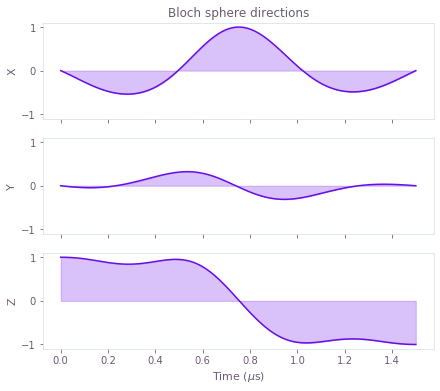

In [43]:
coherent_frames = robust_ideal_simulation_result.samples

figure = plt.figure()
plot_simulation_noise_directions(figure, robust_point_times, coherent_frames)
plt.show()

## Exercise: Qubit with amplitude noise

Another very common noise process on quantum computers is a miscalibration on the effective Rabi rate, because of noise in the microwave pulse signal generators. The Hamiltonian for a quantum computer with this kind of noise is:

\begin{align*}
H_{\rm total}(t) & = H_{\rm control}(t) + H_{\rm noise}(t), \\
H_{\rm control}(t) & = \Omega_{\rm I}(t) \sigma_{x}/2 + \Omega_{\rm Q}(t) \sigma_{y}/2, \\
H_{\rm noise}(t) & = \eta_{\rm I}(t) \Omega_{\rm I}(t) \sigma_{x}/2 + \eta_{\rm Q}(t) \Omega_{\rm Q}(t) \sigma_{y}/2.
\end{align*}

where $\eta_k(t)$ are stochastic classical noise processes sampled from their corresponding noise spectral densities $S_k(\omega)$. 

As an exercise, repeat the robust control analysis and design process, where you now target creating a Hadamard gate.

In [24]:
# a. Create a simulation of the standard H gate

In [25]:
# b. Plot the simulation of the standard H gate

In [26]:
# c. Create a robust H gate

In [27]:
# d. Plot the robust H gate

In [28]:
# e. Calculate a filter function of a standard H gate and robust H gate

In [29]:
# f. Plot the filter functions of both gates to confirm the robust H gate is robust.

In [30]:
# g. Create a simulation of a simulation of the robust H gate

In [31]:
# h. Plot the simulation of the robust H gate